In [1]:
import numpy as np   # Importo paquete de álgebra lineal
import matplotlib.pyplot as plt   # Importo paquete de gráficos
import math   # Importo paquete de funciones matemáticas
import random   # Importo paquete para generar números pseudoaleatorios
import pandas as pd # Importo paquete para crear tablas.

## Problema 5

El agua de un lago de zonas templadas, al igual que el líquido en un reactor de procesos químicos, está térmicamente estratificada. Cerca de la superficie el agua es tibia y liviana (epilimnion) y en el fondo más fría y densa (hipolimnion). Ambas capas están separadas, aproximadamente, por un plano conocido por thermocline, donde la derivada segunda de la temperatura respecto de la profundidad se hace cero (o la derivada primera tiene su máximo). A esta profundidad el flujo de calor de la superficie al fondo de la capa se puede calcular con la ley de Fourier,
\begin{equation}
J = -k \frac{dT}{dz}
\end{equation}
Dados los datos de la tabla siguiente, correspondientes a la temperatura del líquido de un reactor en función de la profundidad, realice un ajuste de la temperatura y de su derivada en función de la profundidad usando el método de splines. Encuentre la posición aproximada de la thermocline y calcule el flujo de calor a través de la interfaz [tome $k = 0,01\ cal/(s.cm.ºC)$].

\begin{equation}
\begin{matrix}
z(m) & 0,0 & 0,5 & 1,0 & 1,5 & 2,0 & 2,5 & 3,0 \\ 
T (°C) & 70  & 68  & 55  & 22  & 13  & 11  & 10 
\end{matrix}
\end{equation}

In [2]:
# Defino valor de coductividad térmica "k".
k = 0.01   # [k] = cal/(s.cm.°C)

In [3]:
# Importo datos de profundidad "z" y de temperatura "T" desde un archivo .txt.
z,T = np.loadtxt('DATOS_Guia0_Problema6.txt', unpack=True)

Text(0.5, 1.0, 'Mediciones')

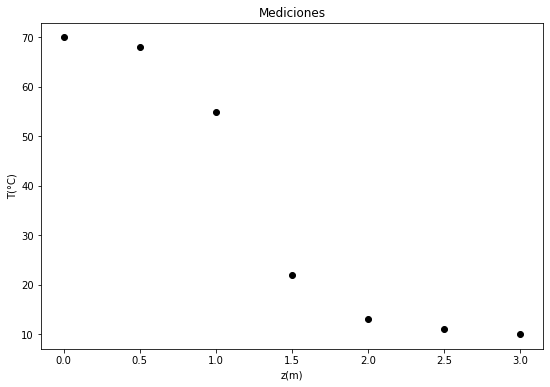

In [4]:
# Gráfico de los puntos a interpolar.
plt.figure(figsize=(9,6))
plt.plot(z,T,'ok',label='Mediciones')
plt.xlabel('z(m)')
plt.ylabel('T(°C)')
plt.title('Mediciones')

In [5]:
# Importo función "spline3", que interpolará los puntos mediante el método SPLINE CÚBICA.
import spline3 as sp3

# El i-ésimo polinomio tiene la forma:
# f_i(x) = a[i] (x-x_i)^3 + b[i] (x-x_i)^2 + c[i] (x-x_i) + d[i]

In [6]:
# Se consideran condiciones de contorno aplicadas en la DERIVADA SEGUNDA. Debemos definir "tipoconds = 1".
tipoconds = 1

# Debemos definir las condiciones de la derivada segunda evaluada en X[0] y X[n-1], en un vector "cond", de tal manera que
# "cond[0]=f''(X[0])" Y "cond[1]=f''(X[n-1])".
cond = np.array([0,0])

In [7]:
# Obtengo la matriz "coeftes" de tamaño "(n-1)*4", que contiene a los vectores "a" (coeficientes cúbicos), "b" (coeficientes
# cuadráticos), "c" (coeficientes lineales) y "d" (coeficientes constantes) en las columnas "1", "2", "3" y "4" respectivamente.

coeftes=sp3.spline3(z,T,tipoconds,cond)
print(coeftes)

# Con esto, ya tengo mis "n-1" polinomios interpolantes, uno por cada intervalo.

[[ -8.67692308   0.          -1.83076923  70.        ]
 [-44.61538462 -13.01538462  -8.33846154  68.        ]
 [115.13846154 -79.93846154 -54.81538462  55.        ]
 [-63.93846154  92.76923077 -48.4         22.        ]
 [  4.61538462  -3.13846154  -3.58461538  13.        ]
 [ -2.52307692   3.78461538  -3.26153846  11.        ]]


In [8]:
# Procederemos a derivar cada uno de los "n-1" polinomios, es decir, cada fila de "coeftes".

# Guardo la cantidad de filas de "coeftes" en una variable "nf".
nf = len(coeftes[:,0])

# Guardo la cantidad de columnas de "coeftes" en una variable "nc".
nc = len(coeftes[0,:])

# Es decir, los "n-1" polinomios a derivar son de grado "grd".
grd = nc-1

In [9]:
# Recordando que los polinomios son de la forma " f_i(x) = a[i] (x-x_i)^3 + b[i] (x-x_i)^2 + c[i] (x-x_i) + d[i] ", cuando los
# derive obtendré otros de la forma " f'_i(x) = 3*a[i] (x-x_i)^2 + 2*b[i] (x-x_i) + c[i] ". Es decir, obtendré un coeficiente
# menos y los almacenaré en una matriz "derivcoeftes" de tamaño "nf,nc-1".
derivcoeftes = np.zeros([nf,nc-1])

# Completo "derivcoeftes", recorriendo sus "nc-1" columnas y recordando que "d/dx a*(x-x_i)^(grd) = grd*a*(x-x_i)^(grd-1)".
for i in range(nc-1):
    # Para todas sus "nf" filas, tomo los coeficientes de la columna "i" de "coeftes" y los multiplico por "grd".
    derivcoeftes[:,i] = grd * coeftes[:,i]
    
    # Reduzco en una unidad el grado "grad", porque derivé.
    grd = grd -1

print(derivcoeftes)

[[ -26.03076923    0.           -1.83076923]
 [-133.84615385  -26.03076923   -8.33846154]
 [ 345.41538462 -159.87692308  -54.81538462]
 [-191.81538462  185.53846154  -48.4       ]
 [  13.84615385   -6.27692308   -3.58461538]
 [  -7.56923077    7.56923077   -3.26153846]]


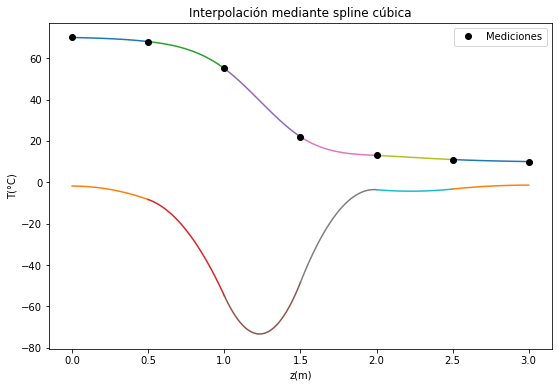

In [10]:
# Graficaré los polinomios interpolantes de "coeftes", y sus respectivas derivadas "derivcoeftes".

# Defino la cantidad "pr" de valores en los que dividiré el intervalo "z[i],z[i+1]". Mayor "pr", mayor precisión.
pr = 80

# Defino vector "absci" que se irá completando con valores de abscisas.
absci = []

# Defino vector "interp" que se irá completando con valores de ordenada correspondientes a la interpolación.
interp = []

# Defino vector "derinterp" que se irá completando con valores de ordenada correspondientes a la derivada de "interp".
derinterp = []

# Comienzo a graficar los "nf" polinomios interpolantes y sus respectivas derivadas.
plt.figure(figsize=(9,6))
for i in range(nf):
    # Defino valores de abscisas correspondientes a este intervalo.
    ABSCI = np.linspace(z[i],z[i+1],pr)

    # Evalúo el polinomio interpolante en x-x_i (recordar forma de los polinomios).
    INTERP = np.polyval(coeftes[i],ABSCI-z[i])
    
    # Evalúo la derivada del polinomio interpolante en x-x_i (recordar forma de los polinomios).
    DERINTERP = np.polyval(derivcoeftes[i],ABSCI-z[i])
    
    # Grafico lo correspondiente a este intervalo.
    plt.plot(ABSCI, INTERP)
    plt.plot(ABSCI, DERINTERP)
    
    # Actualizo los nuevos valores de "absci", "interp" y "derinterp".
    absci.append(ABSCI)
    interp.append(INTERP)
    derinterp.append(DERINTERP)
    
plt.plot(z,T,'ok',label='Mediciones')
plt.xlabel('z(m)')
plt.ylabel('T(°C)')
plt.title('Interpolación mediante spline cúbica')
plt.legend()

In [11]:
# El ejercicio pide encontrar la posición del thermocline, esto es la PROFUNDIDAD a la que se encuentra. Aquella corresponde al
# valor mínimo de la derivada primera, cuyos valores se encuentran almacenados en "derinterp".

# Empleo "np.hstack", que acomoda los elementos del iterable uno al lado del otro, de manera que crea array de una dimensión.
absci = np.hstack(absci)
derinterp = np.hstack(derinterp)

# Calculo el mínimo de la derivada primera.
minder = np.amin(derinterp)
print('El thermocline (valor mínimo de la derivada primera) vale',minder, '°C/cm')

# Calculo la posición de "minder" en "derinterp".
posminder= np.argmin(derinterp)

# Calculo la profundidad a la que se encuentra el thermocline.
zminder= absci[posminder]
print('La profundidad (posición) a la que se encuentra el thermocline es',zminder, 'cm')

# Calculo el flujo de calor a través de la interfaz.
Jint = -k*minder
print('El flujo de calor a través de la interfaz es',Jint, 'cal/(s.cm^2)')

El thermocline (valor mínimo de la derivada primera) vale -73.31269397162684 °C/cm
La profundidad (posición) a la que se encuentra el thermocline es 1.2341772151898733 cm
El flujo de calor a través de la interfaz es 0.7331269397162684 cal/(s.cm^2)


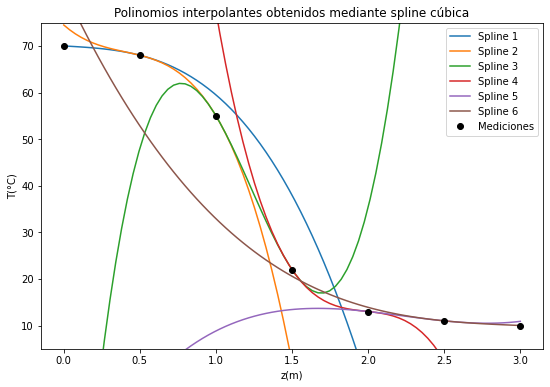

In [12]:
# Mostraremos que en realidad cada polinomio interpolante tiene validez sólo en el intervalo donde fue definido.

plt.figure(figsize=(9,6))

# Defino la cantidad "pr" de valores en los que dividiré las abscisas. Mayor "pr", mayor precisión.
pr = 80

# Defino valores de abscisas correspondientes a este intervalo.
ABSCI2 = np.linspace(min(z),max(z),pr)

# Grafico los "n-1" polinomios interpolantes.
for i in range(len(z)-1):
    # Evalúo el polinomio interpolante en x-x_i (recordar forma de los polinomios). Esta variable se actualiza iteración
    # tras iteración.
    INTERP2 = coeftes[i,0]*(ABSCI2-z[i])**3 + coeftes[i,1]*(ABSCI2-z[i])**2 + coeftes[i,2]*(ABSCI2-z[i]) + coeftes[i,3] 
    
    # Para ir actualizando las labels según "num", uso "label_text = 'Spline {}'.format(num)".
    plt.plot(ABSCI2, INTERP2, label= 'Spline {}'.format(i+1))

# Establezco límites inferior y superior al eje de ordenadas.
plt.ylim([min(T)-5,max(T)+5])

plt.plot(z,T,'ok',label='Mediciones')
plt.xlabel('z(m)')
plt.ylabel('T(°C)')
plt.title('Polinomios interpolantes obtenidos mediante spline cúbica')
plt.legend()